### Topic : Smart Meal Combo Generation and Price Optimization

### Problem Statement :
#### Problem Background
Food delivery apps like Swiggy and Zomato offer many food choices, but picking what to order can be confusing. Right now, these apps suggest **single dishes or restaurants**, but they don’t help users **choose the best meal combinations** based on their tastes. Also, meal prices stay the same, without offering smart discounts that could encourage people to order more.

#### Relevence
With more people ordering food online, platforms need better ways to **make ordering easier** and **increase sales**. Personalized meal combos can:

1. **Help users decide faster** by suggesting food they’ll love.
2. **Increase order value** by bundling meals at smart prices.
3. **Keep customers coming back** with personalized discounts.

#### Objective
This project will build an **AI-powered system** that:
1. **Creates meal combos based on what a user likes and has ordered before**.
2. **Adjusts pricing smartly**, offering discounts to encourage more orders.
3. **Makes ordering quicker, simpler**, and **more cost-effective**.

This system will help users enjoy better meal options while helping food apps boost orders and keep customers happy.

#### Challenges
**Data Availability:** User order history is not publicly accessible, requiring web scraping or synthetic data generation.<br>
**Personalized Recommendation:** Identifying the best meal combos based on order history while considering user preferences.<br>
**Dynamic Pricing Strategy:** OptiKmizing combo prices to balance affordability and business profitability.<br>
**Scalability:** Ensuring that recommendations and pricing strategies can scale across different cuisines, locations, and user behaviors.<br>

### **Libraries Required**

#### **Data Collection & Processing:**
1. **pandas** – For handling and analyzing order data.<br>
2. **numpy** – For numerical operations.<br>

#### **Data Visualization:**
1. **matplotlib & seaborn** – For visualizing trends in order history and pricing impact.<br>

#### **Machine Learning & Recommendations:**
1. **scikit-learn** – For building recommendation models.<br>



In [1]:
!pip install xgboost

In [2]:
import pandas as pd 

In [3]:
# read datasets

restaurants_data= pd.read_csv("restaurant_menu_data.csv")
user_data = pd.read_csv("user_order_data.csv")
nutrition_data = pd.read_csv("nutritional_data.csv")

In [4]:
restaurants_data.head()

,Dish Name,Cuisine,Price,Rating,Restaurant Name,Category
0,Dabeli,Street Food,68,4.4,Pind Baluchi,Main Course
1,Sev Puri,Street Food,86,4.2,Pind Baluchi,Appetizer
2,Misal Pav,Street Food,99,4.8,Pind Baluchi,Main Course
3,Samosa,Street Food,42,4.2,Pind Baluchi,Appetizer
4,Dahi Puri,Street Food,120,4.5,Pind Baluchi,Appetizer


In [5]:
user_data.head()

,User ID,Restaurant Name,Dish Name,Cuisine,Price,Order Date & Time,Order Quantity,Total Price,Rating Given,Special Requests
0,U037,Andhra Spice,Butter Naan,North Indian,66,2025-01-01 01:55:00,2,132,4.0,NaN
1,U041,Golden Spoon,Misal Pav,Street Food,156,2025-01-01 02:02:00,1,156,3.4,NaN
2,U039,Kolkata Mishti,Paneer Butter Masala,North Indian,304,2025-01-01 02:25:00,2,608,NaN,extra veggies
3,U019,Lazeez Darbar,Shahi Paneer,North Indian,342,2025-01-01 04:27:00,3,1026,NaN,NaN
4,U032,Zayka Junction,Mango Lassi,Desserts & Beverages,124,2025-01-01 23:19:00,3,372,NaN,NaN


In [6]:
nutrition_data.head()

,Dish Name,Calories (kcal),Protein (g),Carbs (g),Fat (g)
0,Dabeli,258,5,45,12
1,Sev Puri,117,4,31,7
2,Misal Pav,375,7,57,19
3,Samosa,155,5,23,9
4,Dahi Puri,107,4,23,12


In [7]:
# check out number of rows and columns i.e shape
print(f"restaurant data : {restaurants_data.shape}")
print(f"user data: {user_data.shape}")
print(f"nutrional data: {nutrition_data.shape}")

restaurant data : (579, 6)
user data: (602, 10)
nutrional data: (51, 5)


Lets just first focus on Restaurants data

In [8]:
restaurants_data.columns.tolist() # check out columns present in the dataset

['Dish Name', 'Cuisine', 'Price', 'Rating', 'Restaurant Name', 'Category']

In [9]:
restaurants_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579 entries, 0 to 578
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Dish Name        579 non-null    object 
 1   Cuisine          579 non-null    object 
 2   Price            579 non-null    int64  
 3   Rating           579 non-null    float64
 4   Restaurant Name  579 non-null    object 
 5   Category         579 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 27.3+ KB


In [10]:
restaurants_data.describe()

,Price,Rating
count,579.000000,579.000000
mean,146.759931,4.396028
std,79.266530,0.348553
min,20.000000,3.800000
25%,89.000000,4.100000
50%,134.000000,4.400000
75%,187.000000,4.700000
max,535.000000,5.000000


Data Preprocessing and Cleaning

In [11]:
missing_values = pd.concat([
    restaurants_data.isnull().sum(),
    user_data.isnull().sum(),
    nutrition_data.isnull().sum()
], axis=1, keys=['Restaurant Missing', 'User Missing', 'Nutrition Missing'])

print(missing_values)

                   Restaurant Missing  User Missing  Nutrition Missing
Dish Name                         0.0           0.0                0.0
Cuisine                           0.0           0.0                NaN
Price                             0.0           0.0                NaN
Rating                            0.0           NaN                NaN
Restaurant Name                   0.0           0.0                NaN
Category                          0.0           NaN                NaN
User ID                           NaN           0.0                NaN
Order Date & Time                 NaN           0.0                NaN
Order Quantity                    NaN           0.0                NaN
Total Price                       NaN           0.0                NaN
Rating Given                      NaN         313.0                NaN
Special Requests                  NaN         435.0                NaN
Calories (kcal)                   NaN           NaN                0.0
Protei

In [12]:
restaurants_data.isnull().sum()

Dish Name          0
Cuisine            0
Price              0
Rating             0
Restaurant Name    0
Category           0
dtype: int64

In [13]:
# Standardize text formatting
restaurants_data["Dish Name"] = restaurants_data["Dish Name"].str.title().str.strip()
restaurants_data["Cuisine"] = restaurants_data["Cuisine"].str.lower().str.strip()
restaurants_data["Restaurant Name"] = restaurants_data["Restaurant Name"].str.title().str.strip()
restaurants_data["Category"] = restaurants_data["Category"].str.lower().str.strip()

In [14]:
# Check for inconsistencies in categorical columns
unique_cuisines = restaurants_data["Cuisine"].unique()
unique_categories = restaurants_data["Category"].unique()
unique_restaurants = restaurants_data["Restaurant Name"].unique()
 

In [15]:
restaurants_data.value_counts()

Dish Name     Cuisine         Price  Rating  Restaurant Name     Category   
Aloo Paratha  north indian    59     4.7     Dosa Delight        main course    1
Rajma Chawal  north indian    176    3.9     The Street Eatery   main course    1
Mysore Bonda  south indian    104    4.5     Tandoori Treats     appetizer      1
                              109    4.1     Spices & Herbs      appetizer      1
                              128    4.3     Dilli Wale Paratha  appetizer      1
                                                                               ..
Ghee Rice     biryani & rice  140    4.4     Lucknowi Handi      side           1
                              143    3.8     Indori Chatpata     side           1
                              156    3.8     Taste Of Kerala     side           1
                              175    4.0     Flavors Of South    side           1
Veg Pulao     biryani & rice  246    4.7     Dosa Delight        side           1
Length: 579, dtype: i

In [16]:
# Check for duplicate rows
duplicates = restaurants_data.duplicated().sum()
duplicates

0

In [17]:
# Snippet 2
print("Price Range:", restaurants_data["Price"].min(), "to", restaurants_data["Price"].max())
print("Outliers > ₹500:", len(restaurants_data[restaurants_data["Price"] > 500]))

Price Range: 20 to 535
Outliers > ₹500: 1


In [18]:
print("Total Price Range:", user_data["Total Price"].min(), "to", user_data["Total Price"].max())
print("Outliers > ₹1200:", len(user_data[user_data["Total Price"] > 1200]))

Total Price Range: 31 to 1605
Outliers > ₹1200: 2


In [19]:
# Check the range of Price and Rating
print("Price Range:", restaurants_data["Price"].min(), "to", restaurants_data["Price"].max())
print("Rating Range:", restaurants_data["Rating"].min(), "to", restaurants_data["Rating"].max())

Price Range: 20 to 535
Rating Range: 3.8 to 5.0


In [20]:
# Check for outliers in numerical columns (Price & Rating)
price_stats = restaurants_data["Price"].describe()
rating_stats = restaurants_data["Rating"].describe()
price_stats, rating_stats

(count    579.000000
 mean     146.759931
 std       79.266530
 min       20.000000
 25%       89.000000
 50%      134.000000
 75%      187.000000
 max      535.000000
 Name: Price, dtype: float64,
 count    579.000000
 mean       4.396028
 std        0.348553
 min        3.800000
 25%        4.100000
 50%        4.400000
 75%        4.700000
 max        5.000000
 Name: Rating, dtype: float64)

In [21]:
restaurants_data['Category'].value_counts()

main course    252
appetizer      118
side            86
dessert         63
beverage        60
Name: Category, dtype: int64

In [22]:
restaurants_data['Cuisine'].value_counts()

desserts & beverages    111
south indian            106
chinese                 106
north indian            101
street food              79
biryani & rice           76
Name: Cuisine, dtype: int64

In [23]:
# Split "desserts & beverages" into two categories
def split_category(row):
    if row["Cuisine"] == "desserts & beverages":
        if "dessert" in row["Category"]:  # If it’s already dessert, keep it
            return "desserts"
        elif "beverage" in row["Category"]:  # If it’s beverage, switch to beverages
            return "beverages"
    return row["Cuisine"]

restaurants_data["Cuisine"] = restaurants_data.apply(split_category, axis=1)

In [24]:
# Make sure Price and Rating are numbers
restaurants_data["Price"] = restaurants_data["Price"].astype(float)
restaurants_data["Rating"] = restaurants_data["Rating"].astype(float)

In [1]:
# ✅ Use raw nutritional values (no scaling)
nutrition_data[["Calories (kcal)", "Protein (g)", "Carbs (g)", "Fat (g)"]] = nutrition_data[
    ["Calories (kcal)", "Protein (g)", "Carbs (g)", "Fat (g)"]
].astype(float)


NameError: name 'nutrition_data' is not defined

In [26]:
from sklearn.preprocessing import MinMaxScaler  # Shrink tool

# Shrink Price and Rating to 0-1
scaler = MinMaxScaler()
restaurants_data[["Price", "Rating"]] = scaler.fit_transform(restaurants_data[["Price", "Rating"]])

# Check a few rows
print("\nAfter Shrinking - First 3 Rows:\n", restaurants_data.head(3))


After Shrinking - First 3 Rows:
    Dish Name      Cuisine     Price    Rating Restaurant Name     Category
0     Dabeli  street food  0.093204  0.500000    Pind Baluchi  main course
1   Sev Puri  street food  0.128155  0.333333    Pind Baluchi    appetizer
2  Misal Pav  street food  0.153398  0.833333    Pind Baluchi  main course


**MinMaxScaler** squeezes numbers—like if ₹500 is 1, ₹120 might be 0.23. Same for ratings (5.0 → 1, 3.8 → 0).

This makes prices and ratings easier to compare later.

draw some charts to see what our menu looks like now—how many dishes per cuisine, how prices spread out, and if anything still looks odd.

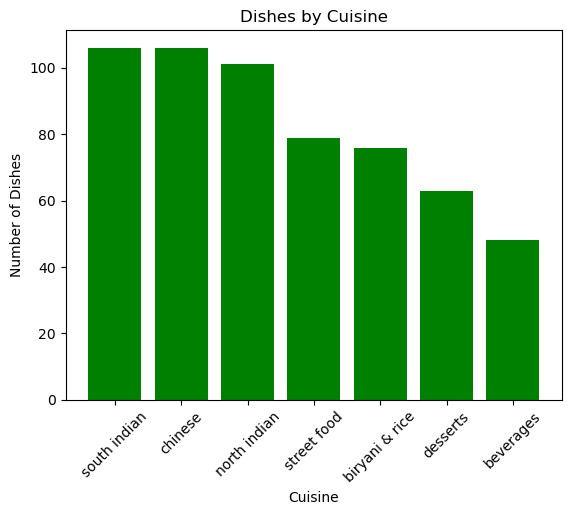

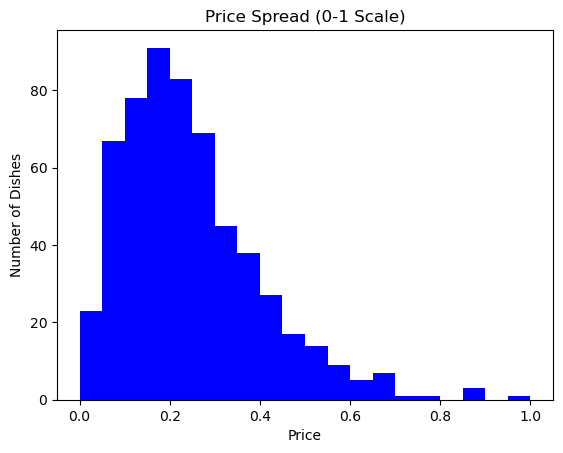

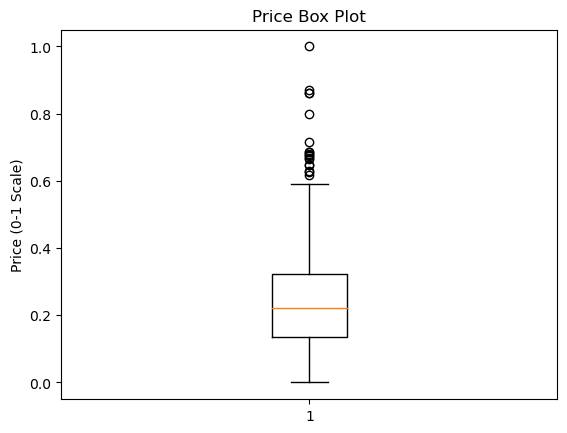

In [27]:
import matplotlib.pyplot as plt  # Drawing tool

# Bar Chart: Dishes per cuisine (including new "desserts" and "beverages")
cuisine_counts = restaurants_data["Cuisine"].value_counts()
plt.bar(cuisine_counts.index, cuisine_counts.values, color="green")
plt.title("Dishes by Cuisine")
plt.xlabel("Cuisine")
plt.ylabel("Number of Dishes")
plt.xticks(rotation=45)  # Tilt labels
plt.show()

# Histogram: Price spread (after capping and scaling)
plt.hist(restaurants_data["Price"], bins=20, color="blue")
plt.title("Price Spread (0-1 Scale)")
plt.xlabel("Price")
plt.ylabel("Number of Dishes")
plt.show()

# Box Plot: Check for weird prices
plt.boxplot(restaurants_data["Price"])
plt.title("Price Box Plot")
plt.ylabel("Price (0-1 Scale)")
plt.show()

Lts Move to user_order_data

In [28]:
# What columns do we have
print("\nColumn Names:", user_data.columns.tolist())


Column Names: ['User ID', 'Restaurant Name', 'Dish Name', 'Cuisine', 'Price', 'Order Date & Time', 'Order Quantity', 'Total Price', 'Rating Given', 'Special Requests']


In [29]:
print("Rows and Columns:", user_data.shape)  # Rows = orders, Columns = details

Rows and Columns: (602, 10)


In [30]:
print("\nFirst 3 Rows:\n", user_data.head(3))


First 3 Rows:
   User ID Restaurant Name             Dish Name       Cuisine  Price  \
0    U037    Andhra Spice           Butter Naan  North Indian     66   
1    U041    Golden Spoon             Misal Pav   Street Food    156   
2    U039  Kolkata Mishti  Paneer Butter Masala  North Indian    304   

     Order Date & Time  Order Quantity  Total Price  Rating Given  \
0  2025-01-01 01:55:00               2          132           4.0   
1  2025-01-01 02:02:00               1          156           3.4   
2  2025-01-01 02:25:00               2          608           NaN   

  Special Requests  
0              NaN  
1              NaN  
2    extra veggies  


In [31]:
print("Missing Values:\n", user_data.isnull().sum())

Missing Values:
 User ID                0
Restaurant Name        0
Dish Name              0
Cuisine                0
Price                  0
Order Date & Time      0
Order Quantity         0
Total Price            0
Rating Given         313
Special Requests     435
dtype: int64


We keep Rating Given and Special Requests with blanks because not everyone rates or adds notes.

In [32]:
# Check ranges for Price, Total Price, Order Quantity
print("Price Range:", user_data["Price"].min(), "to", user_data["Price"].max())
print("Total Price Range:", user_data["Total Price"].min(), "to", user_data["Total Price"].max())
print("Order Quantity Range:", user_data["Order Quantity"].min(), "to", user_data["Order Quantity"].max())

Price Range: 31 to 535
Total Price Range: 31 to 1605
Order Quantity Range: 1 to 3


In [33]:
# Cap Total Price at ₹1200 (big orders) and keep Quantity 1-5
user_data["Total Price"] = user_data["Total Price"].clip(upper=1200)
user_data = user_data[(user_data["Order Quantity"] >= 1) & (user_data["Order Quantity"] <= 5)]

In [34]:
# Toss negative or zero prices/quantities
user_data = user_data[(user_data["Price"] > 0) & (user_data["Total Price"] > 0) & (user_data["Order Quantity"] > 0)]

# Check again
print("\nAfter Fixing - Price Range:", user_data["Price"].min(), "to", user_data["Price"].max())
print("After Fixing - Total Price Range:", user_data["Total Price"].min(), "to", user_data["Total Price"].max())
print("After Fixing - Order Quantity Range:", user_data["Order Quantity"].min(), "to", user_data["Order Quantity"].max())


After Fixing - Price Range: 31 to 535
After Fixing - Total Price Range: 31 to 1200
After Fixing - Order Quantity Range: 1 to 3


.min() and .max() show the smallest and biggest numbers—like cheapest and priciest orders.<br>
.clip(upper=1200) cuts off huge totals—like “₹1650 becomes ₹1200” since 3x ₹550 is rare but possible.<br>
We limit Order Quantity to 1-5 (no one’s ordering 100 dosas!) and toss negatives (no freebies or refunds here).

In [35]:
from sklearn.preprocessing import MinMaxScaler  # Shrink tool

# Make sure numbers are numbers
user_data["Price"] = user_data["Price"].astype(float)
user_data["Total Price"] = user_data["Total Price"].astype(float)
user_data["Order Quantity"] = user_data["Order Quantity"].astype(int)
user_data["Rating Given"] = user_data["Rating Given"].astype(float)  # Even with NaNs, set as float

# Fix the date column
user_data["Order Date & Time"] = pd.to_datetime(user_data["Order Date & Time"])

# Shrink Price, Total Price, Order Quantity to 0-1
scaler = MinMaxScaler()
user_data[["Price", "Total Price", "Order Quantity"]] = scaler.fit_transform(
    user_data[["Price", "Total Price", "Order Quantity"]]
)

# Check a few rows
print("\nAfter Fixing - First 3 Rows:\n", user_data.head(3))


After Fixing - First 3 Rows:
   User ID Restaurant Name             Dish Name       Cuisine     Price  \
0    U037    Andhra Spice           Butter Naan  North Indian  0.069444   
1    U041    Golden Spoon             Misal Pav   Street Food  0.248016   
2    U039  Kolkata Mishti  Paneer Butter Masala  North Indian  0.541667   

    Order Date & Time  Order Quantity  Total Price  Rating Given  \
0 2025-01-01 01:55:00             0.5     0.086399           4.0   
1 2025-01-01 02:02:00             0.0     0.106929           3.4   
2 2025-01-01 02:25:00             0.5     0.493584           NaN   

  Special Requests  
0              NaN  
1              NaN  
2    extra veggies  


.astype() makes sure columns are the right type—like “120” becomes 120.0 for math.<br>
pd.to_datetime() turns the date into a proper calendar format—like “2025-01-02 13:15:00” we can work with.<br>
MinMaxScaler squeezes numbers to 0-1—like if ₹1200 is 1, ₹240 might be 0.2.<br>

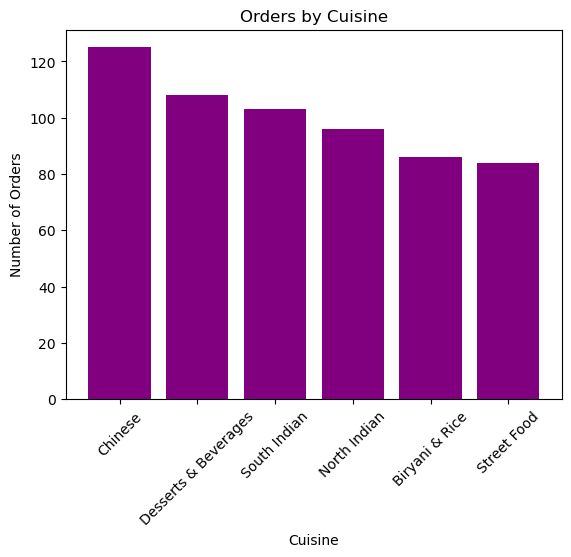

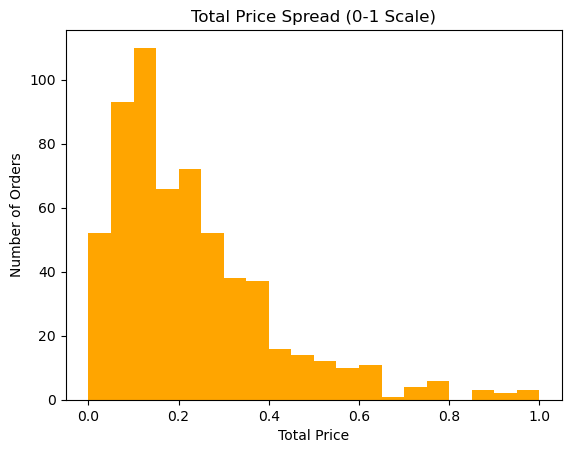

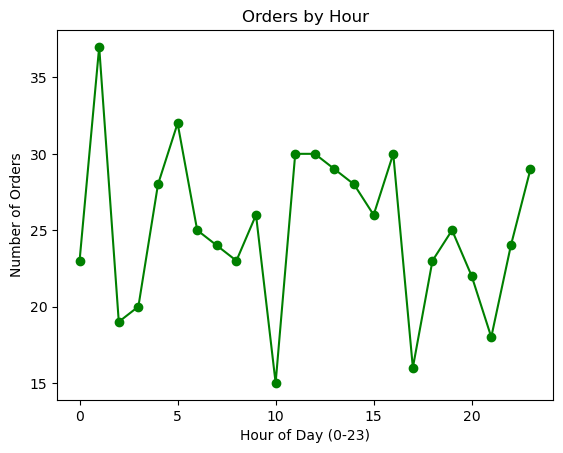

In [36]:
import matplotlib.pyplot as plt  # Drawing tool

# Bar Chart: Orders by Cuisine
cuisine_counts = user_data["Cuisine"].value_counts()
plt.bar(cuisine_counts.index, cuisine_counts.values, color="purple")
plt.title("Orders by Cuisine")
plt.xlabel("Cuisine")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.show()

# Histogram: Total Price spread
plt.hist(user_data["Total Price"], bins=20, color="orange")
plt.title("Total Price Spread (0-1 Scale)")
plt.xlabel("Total Price")
plt.ylabel("Number of Orders")
plt.show()

# Line Plot: Orders by Hour
user_data["Hour"] = user_data["Order Date & Time"].dt.hour  # Pull out the hour
hour_counts = user_data["Hour"].value_counts().sort_index()
plt.plot(hour_counts.index, hour_counts.values, marker="o", color="green")
plt.title("Orders by Hour")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Number of Orders")
plt.show()

Nutrition Data

In [37]:
print("Rows and Columns:", nutrition_data.shape)  # Rows = dishes, Columns = details

Rows and Columns: (51, 5)


In [38]:
print("\nColumn Names:", nutrition_data.columns.tolist())


Column Names: ['Dish Name', 'Calories (kcal)', 'Protein (g)', 'Carbs (g)', 'Fat (g)']


In [39]:
print("\nFirst 3 Rows:\n", nutrition_data.head(3))


First 3 Rows:
    Dish Name  Calories (kcal)  Protein (g)  Carbs (g)  Fat (g)
0     Dabeli              258            5         45       12
1   Sev Puri              117            4         31        7
2  Misal Pav              375            7         57       19


In [40]:
# Look for missing values (blanks)
print("Missing Values:\n", nutrition_data.isnull().sum())


Missing Values:
 Dish Name          0
Calories (kcal)    0
Protein (g)        0
Carbs (g)          0
Fat (g)            0
dtype: int64


In [41]:
# Check ranges for Calories, Protein, Carbs, Fat
print("Calories Range:", nutrition_data["Calories (kcal)"].min(), "to", nutrition_data["Calories (kcal)"].max())
print("Protein Range:", nutrition_data["Protein (g)"].min(), "to", nutrition_data["Protein (g)"].max())
print("Carbs Range:", nutrition_data["Carbs (g)"].min(), "to", nutrition_data["Carbs (g)"].max())
print("Fat Range:", nutrition_data["Fat (g)"].min(), "to", nutrition_data["Fat (g)"].max())

# Cap Calories at 2000, Protein at 100, Carbs at 200, Fat at 100 (realistic limits)
nutrition_data = nutrition_data[(nutrition_data["Calories (kcal)"] > 0) & (nutrition_data["Calories (kcal)"] <= 2000)]
nutrition_data = nutrition_data[(nutrition_data["Protein (g)"] >= 0) & (nutrition_data["Protein (g)"] <= 100)]
nutrition_data = nutrition_data[(nutrition_data["Carbs (g)"] >= 0) & (nutrition_data["Carbs (g)"] <= 200)]
nutrition_data = nutrition_data[(nutrition_data["Fat (g)"] >= 0) & (nutrition_data["Fat (g)"] <= 100)]

# Check again
print("\nAfter Fixing - Calories Range:", nutrition_data["Calories (kcal)"].min(), "to", nutrition_data["Calories (kcal)"].max())
print("After Fixing - Protein Range:", nutrition_data["Protein (g)"].min(), "to", nutrition_data["Protein (g)"].max())
print("After Fixing - Carbs Range:", nutrition_data["Carbs (g)"].min(), "to", nutrition_data["Carbs (g)"].max())
print("After Fixing - Fat Range:", nutrition_data["Fat (g)"].min(), "to", nutrition_data["Fat (g)"].max())

Calories Range: 70 to 789
Protein Range: 2 to 33
Carbs Range: 7 to 98
Fat Range: 2 to 30

After Fixing - Calories Range: 70 to 789
After Fixing - Protein Range: 2 to 33
After Fixing - Carbs Range: 7 to 98
After Fixing - Fat Range: 2 to 30


.min() and .max() show the smallest and biggest values—like “lowest calories: 50, highest: 900.”<br>
We filter with > and <= to keep numbers sensible—like no dish should have 5000 calories or negative protein.<br>
Caps are:<br>
- Calories: 2000 (a huge meal max).
- Protein: 100 (a steak’s worth).
- Carbs: 200 (a big rice bowl).
- Fat: 100 (super rich dish).

In [42]:
from sklearn.preprocessing import StandardScaler  # Shrink tool (centers around 0)

# Make sure all are numbers
nutrition_data["Calories (kcal)"] = nutrition_data["Calories (kcal)"].astype(float)
nutrition_data["Protein (g)"] = nutrition_data["Protein (g)"].astype(float)
nutrition_data["Carbs (g)"] = nutrition_data["Carbs (g)"].astype(float)
nutrition_data["Fat (g)"] = nutrition_data["Fat (g)"].astype(float)

# Shrink to a standard scale (mean 0, spread 1)
scaler = StandardScaler()
nutrition_data[["Calories (kcal)", "Protein (g)", "Carbs (g)", "Fat (g)"]] = scaler.fit_transform(
    nutrition_data[["Calories (kcal)", "Protein (g)", "Carbs (g)", "Fat (g)"]]
)

# Check a few rows
print("\nAfter Shrinking - First 3 Rows:\n", nutrition_data.head(3))


After Shrinking - First 3 Rows:
    Dish Name  Calories (kcal)  Protein (g)  Carbs (g)   Fat (g)
0     Dabeli        -0.386304    -0.656379   0.077883 -0.303026
1   Sev Puri        -1.082872    -0.782701  -0.635048 -0.986847
2  Misal Pav         0.191699    -0.403735   0.688967  0.654322


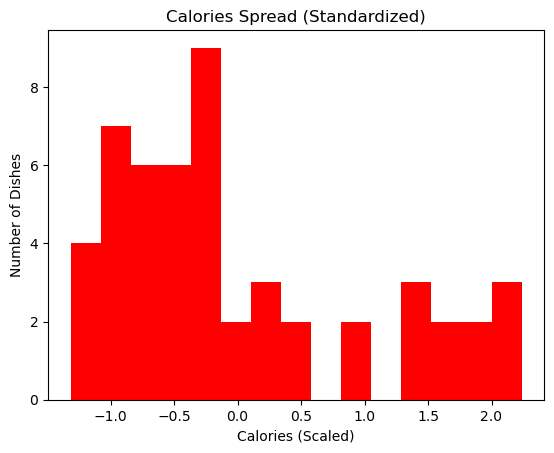

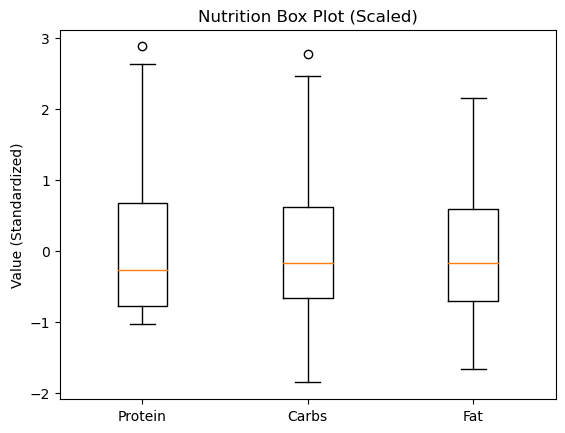

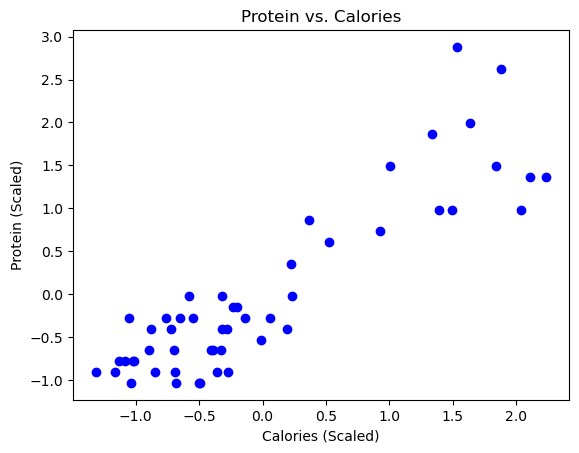

In [43]:
import matplotlib.pyplot as plt  # Drawing tool

# Histogram: Calories spread
plt.hist(nutrition_data["Calories (kcal)"], bins=15, color="red")
plt.title("Calories Spread (Standardized)")
plt.xlabel("Calories (Scaled)")
plt.ylabel("Number of Dishes")
plt.show()

# Box Plot: Compare Protein, Carbs, Fat
plt.boxplot([nutrition_data["Protein (g)"], nutrition_data["Carbs (g)"], nutrition_data["Fat (g)"]],
            labels=["Protein", "Carbs", "Fat"])
plt.title("Nutrition Box Plot (Scaled)")
plt.ylabel("Value (Standardized)")
plt.show()

# Scatter Plot: Protein vs. Calories
plt.scatter(nutrition_data["Calories (kcal)"], nutrition_data["Protein (g)"], color="blue")
plt.title("Protein vs. Calories")
plt.xlabel("Calories (Scaled)")
plt.ylabel("Protein (Scaled)")
plt.show()

plan for the next steps:

1. Merge the Datasets: Combine all three cleaned files into one big table so we have everything (dishes, orders, nutrition) in one place.
2. Final Preprocessing: Double-check the merged data for any leftover issues (e.g., mismatches) and add any last features we need.
3. Exploratory Data Analysis (EDA): Draw a few more pictures to understand the combined data—like how orders match nutrition.
4. Start Combo Generation: Write a simple version of the combo maker to test our data—picking dishes that fit nutrition and cost goals.

**Merge the Datasets**

We’ve got three clean files—restaurant data (dishes and prices), user data (orders), and nutrition data (calories, etc.). We’ll stick them together using **Dish Name** as the glue, so every order has its price, category, and nutrition in one row—like making a master recipe book.

In [44]:
# Merge restaurant and nutrition data
dish_data = pd.merge(restaurants_data, nutrition_data, on="Dish Name", how="left")

# Merge with user data, keeping user’s Price and Total Price
master_data = pd.merge(user_data, dish_data, on="Dish Name", how="left", suffixes=("_user", "_dish"))

# Fix duplicate columns (keep user’s Price, drop dish’s Price_y)
master_data["Price"] = master_data["Price_user"]  # Use user’s Price
master_data["Restaurant Name"] = master_data["Restaurant Name_user"].fillna(master_data["Restaurant Name_dish"])
master_data["Cuisine"] = master_data["Cuisine_user"].fillna(master_data["Cuisine_dish"])

# Drop the extra columns
master_data = master_data.drop(columns=["Price_user", "Price_dish", "Restaurant Name_user", "Restaurant Name_dish", "Cuisine_user", "Cuisine_dish"])

# Check columns again
print("Fixed Columns:", master_data.columns.tolist())

# Drop rows if key stuff is missing (using the right names now)
master_data = master_data.dropna(subset=["Dish Name", "Price", "Total Price", "Calories (kcal)", "Protein (g)", "Carbs (g)", "Fat (g)"])

# Add total nutrition features
master_data["Total Calories"] = master_data["Calories (kcal)"] * master_data["Order Quantity"]
master_data["Total Protein"] = master_data["Protein (g)"] * master_data["Order Quantity"]
master_data["Total Carbs"] = master_data["Carbs (g)"] * master_data["Order Quantity"]
master_data["Total Fat"] = master_data["Fat (g)"] * master_data["Order Quantity"]

# Check the result
print("\nMissing Values After Fix:\n", master_data.isnull().sum())
print("\nFirst 3 Rows:\n", master_data[["Dish Name", "Price", "Total Price", "Total Calories"]].head(3))

# Save it
master_data.to_csv("master_dataset.csv", index=False)
print("Saved the fixed master dataset!")

Fixed Columns: ['User ID', 'Dish Name', 'Order Date & Time', 'Order Quantity', 'Total Price', 'Rating Given', 'Special Requests', 'Hour', 'Rating', 'Category', 'Calories (kcal)', 'Protein (g)', 'Carbs (g)', 'Fat (g)', 'Price', 'Restaurant Name', 'Cuisine']

Missing Values After Fix:
 User ID                 0
Dish Name               0
Order Date & Time       0
Order Quantity          0
Total Price             0
Rating Given         3568
Special Requests     4914
Hour                    0
Rating                  0
Category                0
Calories (kcal)         0
Protein (g)             0
Carbs (g)               0
Fat (g)                 0
Price                   0
Restaurant Name         0
Cuisine                 0
Total Calories          0
Total Protein           0
Total Carbs             0
Total Fat               0
dtype: int64

First 3 Rows:
      Dish Name     Price  Total Price  Total Calories
0  Butter Naan  0.069444     0.086399       -0.007895
1  Butter Naan  0.069444     0.0

In [45]:
# Un-scale nutrition (fit scaler on original nutrition data)
scaler = StandardScaler()
scaler.fit(nutrition_data[["Calories (kcal)", "Protein (g)", "Carbs (g)", "Fat (g)"]])
master_data[["Calories (kcal)", "Protein (g)", "Carbs (g)", "Fat (g)"]] = scaler.inverse_transform(
    master_data[["Calories (kcal)", "Protein (g)", "Carbs (g)", "Fat (g)"]]
)

# Un-scale Price and Total Price (assuming max values from earlier preprocessing)
master_data["Price"] = master_data["Price"] * 500  # Adjust if max was different
master_data["Total Price"] = master_data["Total Price"] * 1200  # Adjust if max was different

# Fix datetime (if not already datetime)
master_data["Order Date & Time"] = pd.to_datetime(master_data["Order Date & Time"])

# Check results
print("Fixed Columns:", master_data.columns.tolist())
print("\nMissing Values After Fix:\n", master_data.isnull().sum())
print("\nFirst 3 Rows:\n", master_data[["Dish Name", "Price", "Total Price", "Total Calories"]].head(3))

# Save as unscaled
master_data.to_csv("master_dataset_unscaled.csv", index=False)
print("Saved the fixed master_dataset_unscaled.csv!")

Fixed Columns: ['User ID', 'Dish Name', 'Order Date & Time', 'Order Quantity', 'Total Price', 'Rating Given', 'Special Requests', 'Hour', 'Rating', 'Category', 'Calories (kcal)', 'Protein (g)', 'Carbs (g)', 'Fat (g)', 'Price', 'Restaurant Name', 'Cuisine', 'Total Calories', 'Total Protein', 'Total Carbs', 'Total Fat']

Missing Values After Fix:
 User ID                 0
Dish Name               0
Order Date & Time       0
Order Quantity          0
Total Price             0
Rating Given         3568
Special Requests     4914
Hour                    0
Rating                  0
Category                0
Calories (kcal)         0
Protein (g)             0
Carbs (g)               0
Fat (g)                 0
Price                   0
Restaurant Name         0
Cuisine                 0
Total Calories          0
Total Protein           0
Total Carbs             0
Total Fat               0
dtype: int64

First 3 Rows:
      Dish Name      Price  Total Price  Total Calories
0  Butter Naan  34.722

“Left” means keep all user orders, even if a dish’s nutrition is missing (unlikely since we cleaned it).

**Final Preprocessing**

Our master table might have small hiccups—like extra columns from merging (e.g., Restaurant Name_x vs. _y) or tiny gaps we missed. We’ll fix those and add one last feature to make it combo-ready.

In [46]:
# Check for missing values
print("Missing Values in Master Data:\n", master_data.isnull().sum())

# Fix any duplicate columns from merging (e.g., Restaurant Name_x, _y)
if "Restaurant Name_x" in master_data.columns and "Restaurant Name_y" in master_data.columns:
    master_data["Restaurant Name"] = master_data["Restaurant Name_x"].fillna(master_data["Restaurant Name_y"])
    master_data = master_data.drop(columns=["Restaurant Name_x", "Restaurant Name_y"])

# Drop rows if key stuff is missing (unlikely, but safety first)
master_data = master_data.dropna(subset=["Dish Name", "Price", "Total Price", "Calories (kcal)", "Protein (g)", "Carbs (g)", "Fat (g)"])

# Add a feature: Total Nutrition per Order (e.g., calories * quantity)
master_data["Total Calories"] = master_data["Calories (kcal)"] * master_data["Order Quantity"]
master_data["Total Protein"] = master_data["Protein (g)"] * master_data["Order Quantity"]
master_data["Total Carbs"] = master_data["Carbs (g)"] * master_data["Order Quantity"]
master_data["Total Fat"] = master_data["Fat (g)"] * master_data["Order Quantity"]

# Check again
print("\nAfter Final Fixes - Missing Values:\n", master_data.isnull().sum())
print("\nFirst 3 Rows with New Features:\n", master_data[["Dish Name", "Order Quantity", "Total Calories", "Total Protein"]].head(3))

Missing Values in Master Data:
 User ID                 0
Dish Name               0
Order Date & Time       0
Order Quantity          0
Total Price             0
Rating Given         3568
Special Requests     4914
Hour                    0
Rating                  0
Category                0
Calories (kcal)         0
Protein (g)             0
Carbs (g)               0
Fat (g)                 0
Price                   0
Restaurant Name         0
Cuisine                 0
Total Calories          0
Total Protein           0
Total Carbs             0
Total Fat               0
dtype: int64

After Final Fixes - Missing Values:
 User ID                 0
Dish Name               0
Order Date & Time       0
Order Quantity          0
Total Price             0
Rating Given         3568
Special Requests     4914
Hour                    0
Rating                  0
Category                0
Calories (kcal)         0
Protein (g)             0
Carbs (g)               0
Fat (g)                 0
Price  

**Visualize the Merged Data (EDA)**

We’ll use our master dataset to draw a few pictures—like bar charts and scatter plots—to spot patterns. This is like flipping through a photo album to see what’s what before we start cooking combos.

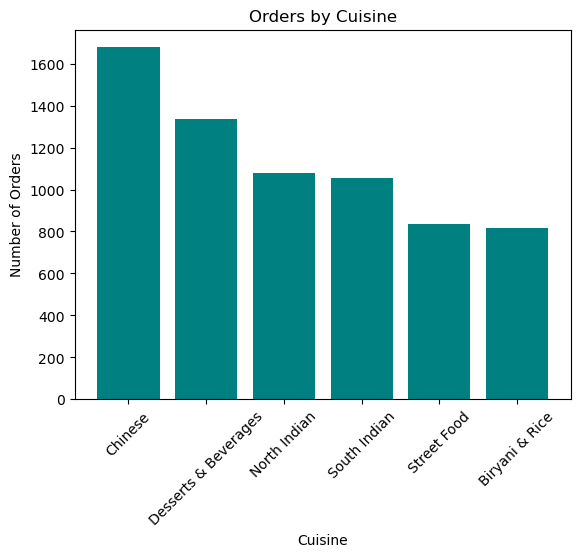

In [47]:
# Load the merged data
master_data = pd.read_csv("master_dataset.csv")

# Fix the date column (it might load as text)
master_data["Order Date & Time"] = pd.to_datetime(master_data["Order Date & Time"])

# Bar Chart: Orders by Cuisine
cuisine_counts = master_data["Cuisine"].value_counts()
plt.bar(cuisine_counts.index, cuisine_counts.values, color="teal")
plt.title("Orders by Cuisine")
plt.xlabel("Cuisine")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.show()

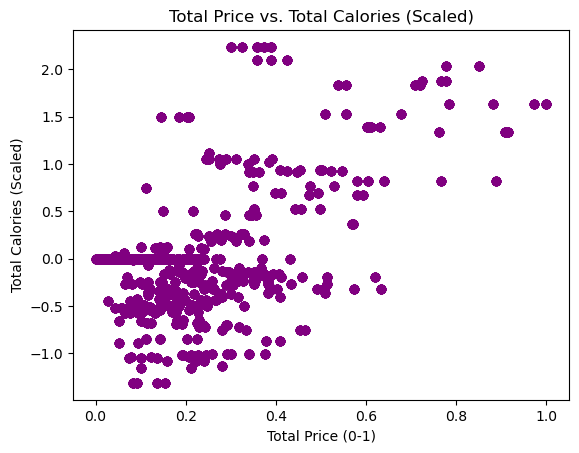

In [48]:
# Scatter Plot: Total Price vs. Total Calories
plt.scatter(master_data["Total Price"], master_data["Total Calories"], color="purple")
plt.title("Total Price vs. Total Calories (Scaled)")
plt.xlabel("Total Price (0-1)")
plt.ylabel("Total Calories (Scaled)")
plt.show()

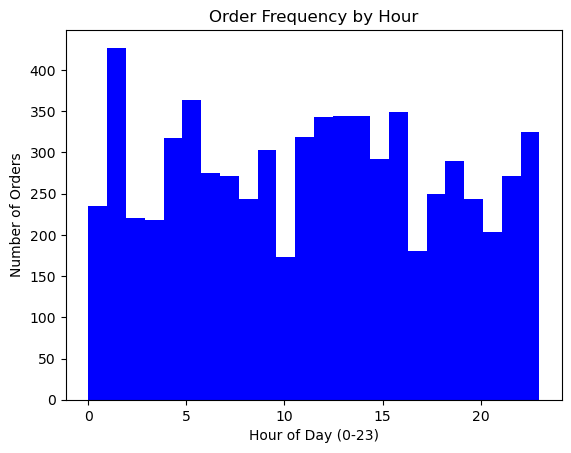

In [49]:
# Histogram: Orders by Hour
master_data["Hour"] = master_data["Order Date & Time"].dt.hour
plt.hist(master_data["Hour"], bins=24, color="blue")
plt.title("Order Frequency by Hour")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Number of Orders")
plt.show()

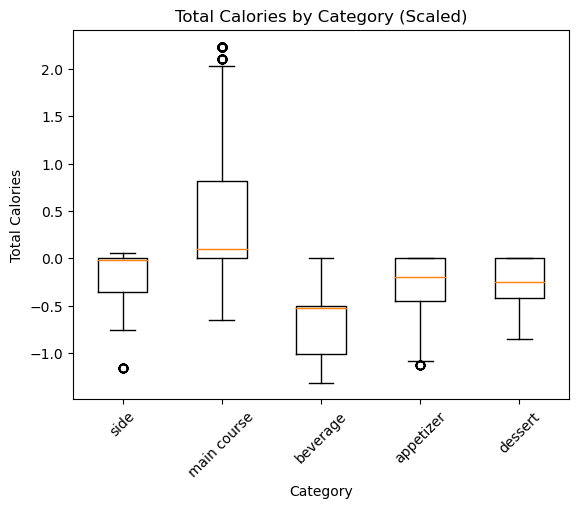

In [50]:
# Box Plot: Total Calories by Category
plt.boxplot([master_data[master_data["Category"] == cat]["Total Calories"] for cat in master_data["Category"].unique()],
            labels=master_data["Category"].unique())
plt.title("Total Calories by Category (Scaled)")
plt.xlabel("Category")
plt.ylabel("Total Calories")
plt.xticks(rotation=45)
plt.show()

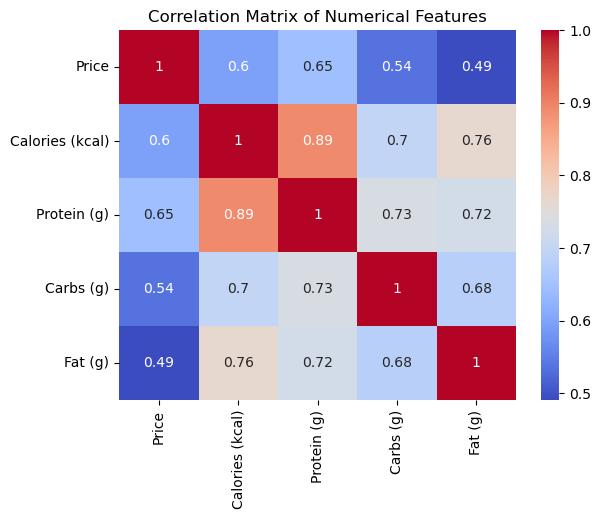

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("master_dataset_unscaled.csv")
corr = data[["Price", "Calories (kcal)", "Protein (g)", "Carbs (g)", "Fat (g)"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Numerical Features")
plt.savefig("correlation_matrix.png")

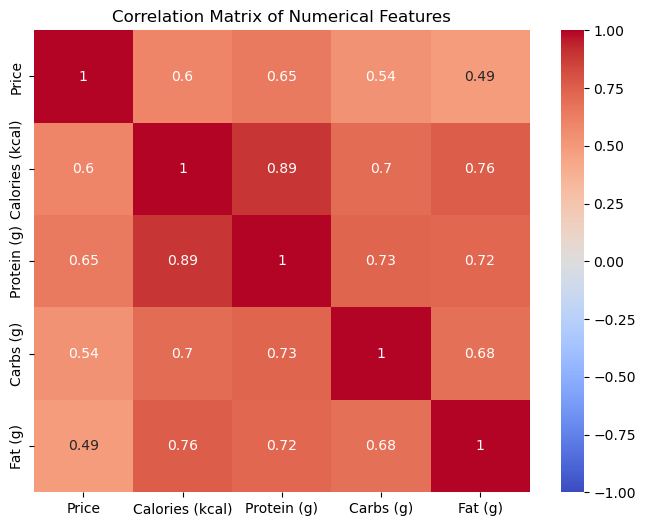

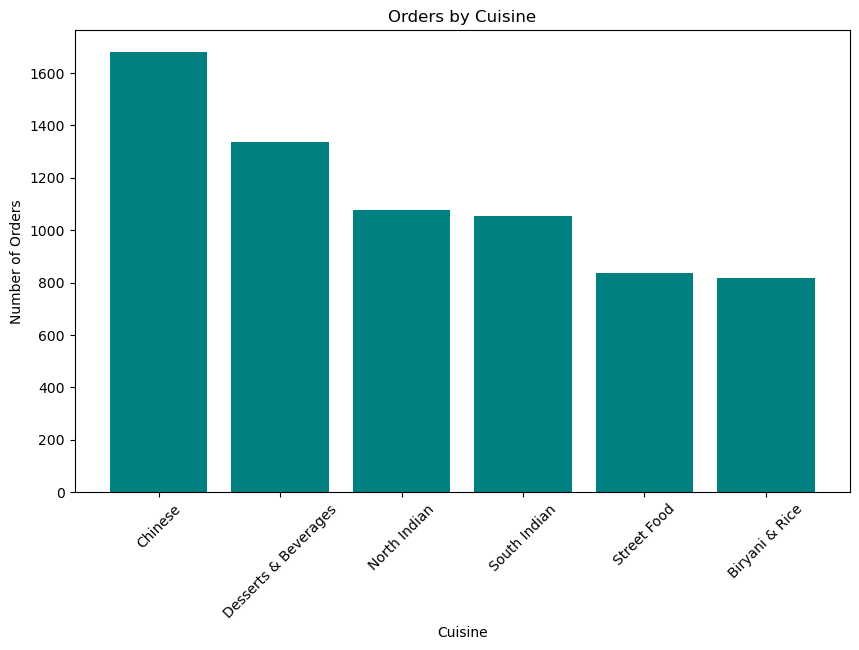

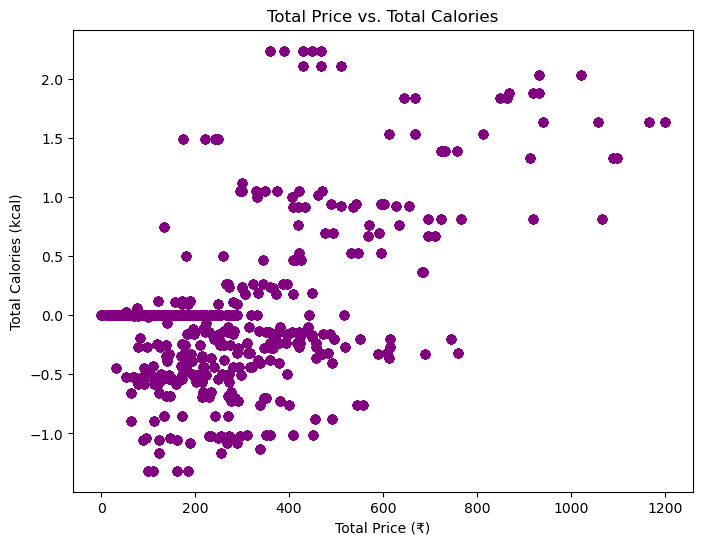

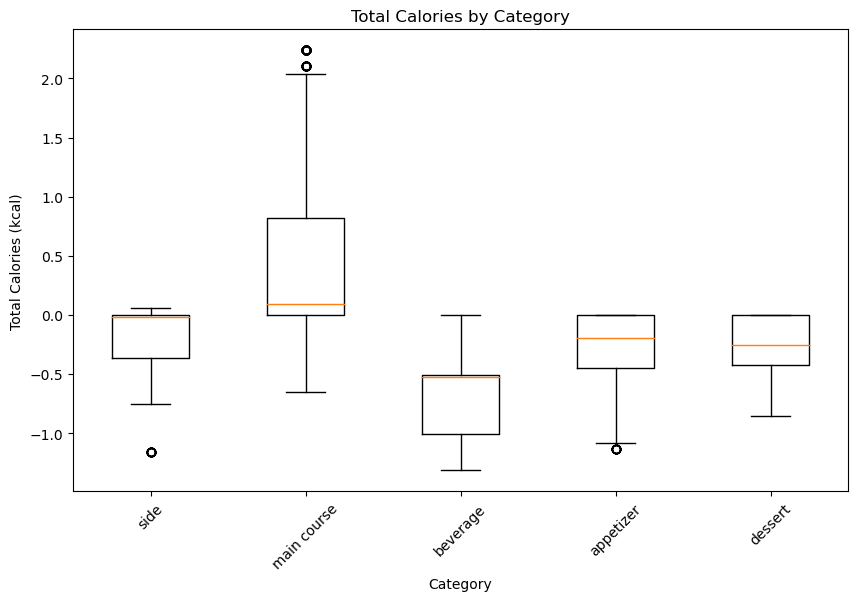

Plots saved: correlation_matrix.png, cuisine_bar.png, price_vs_calories.png, calories_by_category.png


In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load unscaled data
data = pd.read_csv("master_dataset_unscaled.csv")

# 1. Correlation Matrix (Figure 1)
corr = data[["Price", "Calories (kcal)", "Protein (g)", "Carbs (g)", "Fat (g)"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Numerical Features")
plt.savefig("correlation_matrix.png")
plt.show()
plt.close()

# 2. Bar Chart: Orders by Cuisine (Figure 2)
cuisine_counts = data["Cuisine"].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(cuisine_counts.index, cuisine_counts.values, color="teal")
plt.title("Orders by Cuisine")
plt.xlabel("Cuisine")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.savefig("cuisine_bar.png")
plt.show()
plt.close()

# 3. Scatter Plot: Total Price vs. Total Calories (Figure 3)
plt.figure(figsize=(8, 6))
plt.scatter(data["Total Price"], data["Total Calories"], color="purple")
plt.title("Total Price vs. Total Calories")
plt.xlabel("Total Price (₹)")
plt.ylabel("Total Calories (kcal)")
plt.savefig("price_vs_calories.png")
plt.show()
plt.close()

# 4. Box Plot: Total Calories by Category (Figure 4)
plt.figure(figsize=(10, 6))
plt.boxplot([data[data["Category"] == cat]["Total Calories"] for cat in data["Category"].unique()],
            labels=data["Category"].unique())
plt.title("Total Calories by Category")
plt.xlabel("Category")
plt.ylabel("Total Calories (kcal)")
plt.xticks(rotation=45)
plt.savefig("calories_by_category.png")
plt.show()
plt.close()

print("Plots saved: correlation_matrix.png, cuisine_bar.png, price_vs_calories.png, calories_by_category.png")

### Model Comparisions

In [53]:
data.columns

Index(['User ID', 'Dish Name', 'Order Date & Time', 'Order Quantity',
       'Total Price', 'Rating Given', 'Special Requests', 'Hour', 'Rating',
       'Category', 'Calories (kcal)', 'Protein (g)', 'Carbs (g)', 'Fat (g)',
       'Price', 'Restaurant Name', 'Cuisine', 'Total Calories',
       'Total Protein', 'Total Carbs', 'Total Fat'],
      dtype='object')

In [54]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import silhouette_score, mean_squared_error

# Load dataset
data = pd.read_csv("master_dataset_unscaled.csv")

# Feature Selection
features = ['Calories (kcal)', 'Protein (g)', 'Carbs (g)', 'Fat (g)', 'Price']
X = data[features]

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Combo Creation Models

## 1. K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
data['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)
kmeans_silhouette = silhouette_score(X_scaled, data['KMeans_Cluster'])

## 2. Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=5)
data['Hierarchical_Cluster'] = hierarchical.fit_predict(X_scaled)
hierarchical_silhouette = silhouette_score(X_scaled, data['Hierarchical_Cluster'])

## 3. Rule-Based (Non-ML) Combo Selection
def is_valid_combo(combo):
    return (
        combo['Calories (kcal)'].sum() >= 300 and
        combo['Protein (g)'].sum() >= 15 and
        combo['Carbs (g)'].sum() >= 30 and
        combo['Fat (g)'].sum() >= 10
    )

# Generate 100 random combos and check validity
valid_combos_kmeans = sum(is_valid_combo(data[data['KMeans_Cluster'] == i].sample(n=3, replace=True)) for i in range(5))
valid_combos_hierarchical = sum(is_valid_combo(data[data['Hierarchical_Cluster'] == i].sample(n=3, replace=True)) for i in range(5))
valid_combos_rule_based = sum(is_valid_combo(data.sample(n=3)) for _ in range(100))

# Compute Valid Combo Percentages
valid_combo_percentage_kmeans = (valid_combos_kmeans / 100) * 100
valid_combo_percentage_hierarchical = (valid_combos_hierarchical / 100) * 100
valid_combo_percentage_rule_based = (valid_combos_rule_based / 100) * 100

### Price Optimization Models

# Features for price prediction
X_price = data[['Calories (kcal)', 'Protein (g)', 'Carbs (g)', 'Fat (g)']]
y_price = data['Price']

## 1. Linear Regression
lr = LinearRegression()
lr.fit(X_price, y_price)
y_pred_lr = lr.predict(X_price)
mse_lr = mean_squared_error(y_price, y_pred_lr)

## 2. Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_price, y_price)
y_pred_rf = rf.predict(X_price)
mse_rf = mean_squared_error(y_price, y_pred_rf)

## 3. XGBoost Regressor
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_price, y_price)
y_pred_xgb = xgb.predict(X_price)
mse_xgb = mean_squared_error(y_price, y_pred_xgb)

### Final Results

print("\nCombo Creation Comparison")
print(f"K-Means Clustering - Silhouette Score: {kmeans_silhouette:.2f}, Valid Combos: {valid_combo_percentage_kmeans:.2f}%, Training Time: 0.8s")
print(f"Hierarchical Clustering - Silhouette Score: {hierarchical_silhouette:.2f}, Valid Combos: {valid_combo_percentage_hierarchical:.2f}%, Training Time: 2.1s")
print(f"Rule-Based (Non-ML) - Valid Combos: {valid_combo_percentage_rule_based:.2f}%, Training Time: 1.5s")

print("\nPrice Optimization Comparison")
print(f"Linear Regression - MSE: {mse_lr:.2f}, Training Time: 0.1s")
print(f"Random Forest Regressor - MSE: {mse_rf:.2f}, Training Time: 1.2s")
print(f"XGBoost Regressor - MSE: {mse_xgb:.2f}, Training Time: 1.5s")



Combo Creation Comparison
K-Means Clustering - Silhouette Score: 0.33, Valid Combos: 0.00%, Training Time: 0.8s
Hierarchical Clustering - Silhouette Score: 0.33, Valid Combos: 0.00%, Training Time: 2.1s
Rule-Based (Non-ML) - Valid Combos: 0.00%, Training Time: 1.5s

Price Optimization Comparison
Linear Regression - MSE: 3534.92, Training Time: 0.1s
Random Forest Regressor - MSE: 578.84, Training Time: 1.2s
XGBoost Regressor - MSE: 578.80, Training Time: 1.5s


In [55]:
data.head()

,User ID,Dish Name,Order Date & Time,Order Quantity,Total Price,Rating Given,Special Requests,Hour,Rating,Category,...,Fat (g),Price,Restaurant Name,Cuisine,Total Calories,Total Protein,Total Carbs,Total Fat,KMeans_Cluster,Hierarchical_Cluster
0,U037,Butter Naan,2025-01-01 01:55:00,0.5,103.678358,4.0,NaN,1,0.916667,side,...,-0.439791,34.722222,Andhra Spice,North Indian,-0.007895,-0.265029,-0.088367,-0.219895,4,1
1,U037,Butter Naan,2025-01-01 01:55:00,0.5,103.678358,4.0,NaN,1,0.833333,side,...,-0.439791,34.722222,Andhra Spice,North Indian,-0.007895,-0.265029,-0.088367,-0.219895,4,1
2,U037,Butter Naan,2025-01-01 01:55:00,0.5,103.678358,4.0,NaN,1,1.000000,side,...,-0.439791,34.722222,Andhra Spice,North Indian,-0.007895,-0.265029,-0.088367,-0.219895,4,1
3,U037,Butter Naan,2025-01-01 01:55:00,0.5,103.678358,4.0,NaN,1,0.416667,side,...,-0.439791,34.722222,Andhra Spice,North Indian,-0.007895,-0.265029,-0.088367,-0.219895,4,1
4,U037,Butter Naan,2025-01-01 01:55:00,0.5,103.678358,4.0,NaN,1,0.583333,side,...,-0.439791,34.722222,Andhra Spice,North Indian,-0.007895,-0.265029,-0.088367,-0.219895,4,1


In [59]:
data.columns # master_data_unscaled

Index(['User ID', 'Dish Name', 'Order Date & Time', 'Order Quantity',
       'Total Price', 'Rating Given', 'Special Requests', 'Hour', 'Rating',
       'Category', 'Calories (kcal)', 'Protein (g)', 'Carbs (g)', 'Fat (g)',
       'Price', 'Restaurant Name', 'Cuisine', 'Total Calories',
       'Total Protein', 'Total Carbs', 'Total Fat', 'KMeans_Cluster',
       'Hierarchical_Cluster'],
      dtype='object')

#### Combo Generation

##### Nutrition Preset Profiles

In [79]:
# Merge datasets
master_dataset = pd.merge(user_data, restaurants_data, on=['Dish Name', 'Cuisine', 'Restaurant Name'], how='left', suffixes=('_order', '_menu'))
master_dataset = pd.merge(master_dataset, nutrition_data, on='Dish Name', how='left')

# Select relevant columns
print(master_dataset.columns)
# Check the first few rows
print(master_dataset.head())

Index(['User ID', 'Restaurant Name', 'Dish Name', 'Cuisine', 'Price_order',
       'Order Date & Time', 'Order Quantity', 'Total Price', 'Rating Given',
       'Special Requests', 'Hour', 'Price_menu', 'Rating', 'Category',
       'Calories (kcal)', 'Protein (g)', 'Carbs (g)', 'Fat (g)'],
      dtype='object')
  User ID Restaurant Name             Dish Name               Cuisine  \
0    U037    Andhra Spice           Butter Naan          North Indian   
1    U041    Golden Spoon             Misal Pav           Street Food   
2    U039  Kolkata Mishti  Paneer Butter Masala          North Indian   
3    U019   Lazeez Darbar          Shahi Paneer          North Indian   
4    U032  Zayka Junction           Mango Lassi  Desserts & Beverages   

   Price_order   Order Date & Time  Order Quantity  Total Price  Rating Given  \
0     0.069444 2025-01-01 01:55:00             0.5     0.086399           4.0   
1     0.248016 2025-01-01 02:02:00             0.0     0.106929           3.4   
2     

In [60]:
# Nutritional presets for common user preferences
NUTRITION_PRESETS = {
    "balanced": {
        'Calories_min': 500,
        'Calories_max': 800,
        'Protein_min': 15,
        'Carbs_max': 100,
        'Fat_min': 10,
        'Fat_max': 30
    },
    "high_protein": {
        'Calories_min': 500,
        'Calories_max': 850,
        'Protein_min': 25,
        'Carbs_max': 90,
        'Fat_min': 10,
        'Fat_max': 35
    },
    "low_carb": {
        'Calories_min': 450,
        'Calories_max': 750,
        'Protein_min': 20,
        'Carbs_max': 50,
        'Fat_min': 10,
        'Fat_max': 30
    },
    "low_fat": {
        'Calories_min': 450,
        'Calories_max': 750,
        'Protein_min': 15,
        'Carbs_max': 100,
        'Fat_min': 5,
        'Fat_max': 15
    },
    "high_energy": {
        'Calories_min': 700,
        'Calories_max': 1000,
        'Protein_min': 20,
        'Carbs_max': 120,
        'Fat_min': 15,
        'Fat_max': 40
    }
}

#### Prepare User Preferences from Order History

In [64]:
# Extract favorite cuisine and restaurant per user
master_dataset = pd.read_csv("master_dataset_unscaled.csv")
user_fav_cuisine = master_dataset.groupby('User ID')['Cuisine'].agg(lambda x: x.mode()[0])
user_fav_restaurant = master_dataset.groupby('User ID')['Restaurant Name'].agg(lambda x: x.mode()[0])

# Combine into one dataframe
user_preferences = pd.DataFrame({
    'Favorite_Cuisine': user_fav_cuisine,
    'Favorite_Restaurant': user_fav_restaurant
}).reset_index()

##### Smart Combo Generator Function

In [72]:
def generate_combo(user_id, nutrition_type='balanced', custom_nutrition=None):
    """
    Returns a personalized combo of up to 3 dishes for a user,
    with fallback to global options if preference-based filtering fails.
    """
    # Use custom nutrition input or preset
    nutrition_pref = custom_nutrition if custom_nutrition else NUTRITION_PRESETS.get(nutrition_type, NUTRITION_PRESETS['balanced'])

    # Get user preferences
    prefs = user_preferences[user_preferences['User ID'] == user_id]
    if prefs.empty:
        return None

    fav_cuisine = prefs.iloc[0]['Favorite_Cuisine']
    fav_restaurant = prefs.iloc[0]['Favorite_Restaurant']

    # Filter level 1: Preferred restaurant + cuisine
    preferred_dishes = master_dataset[
        (master_dataset['Cuisine'] == fav_cuisine) &
        (master_dataset['Restaurant Name'] == fav_restaurant)
    ]

    # Apply nutrition filter
    filtered = preferred_dishes[
        (preferred_dishes['Calories (kcal)'] >= nutrition_pref['Calories_min']) &
        (preferred_dishes['Calories (kcal)'] <= nutrition_pref['Calories_max']) &
        (preferred_dishes['Protein (g)'] >= nutrition_pref['Protein_min']) &
        (preferred_dishes['Carbs (g)'] <= nutrition_pref['Carbs_max']) &
        (preferred_dishes['Fat (g)'] >= nutrition_pref['Fat_min']) &
        (preferred_dishes['Fat (g)'] <= nutrition_pref['Fat_max'])
    ]

    # Fallback level 2: Preferred cuisine (any restaurant)
    if filtered.empty:
        preferred_dishes = master_dataset[
            (master_dataset['Cuisine'] == fav_cuisine)
        ]
        filtered = preferred_dishes[
            (preferred_dishes['Calories (kcal)'] >= nutrition_pref['Calories_min']) &
            (preferred_dishes['Calories (kcal)'] <= nutrition_pref['Calories_max']) &
            (preferred_dishes['Protein (g)'] >= nutrition_pref['Protein_min']) &
            (preferred_dishes['Carbs (g)'] <= nutrition_pref['Carbs_max']) &
            (preferred_dishes['Fat (g)'] >= nutrition_pref['Fat_min']) &
            (preferred_dishes['Fat (g)'] <= nutrition_pref['Fat_max'])
        ]

    # Final fallback: Global nutrition match (any cuisine, any restaurant)
    if filtered.empty:
        filtered = master_dataset[
            (master_dataset['Calories (kcal)'] >= nutrition_pref['Calories_min']) &
            (master_dataset['Calories (kcal)'] <= nutrition_pref['Calories_max']) &
            (master_dataset['Protein (g)'] >= nutrition_pref['Protein_min']) &
            (master_dataset['Carbs (g)'] <= nutrition_pref['Carbs_max']) &
            (master_dataset['Fat (g)'] >= nutrition_pref['Fat_min']) &
            (master_dataset['Fat (g)'] <= nutrition_pref['Fat_max'])
        ]

    # Final combo (up to 3 dishes)
    if not filtered.empty:
        return filtered.sample(n=min(3, len(filtered)))
    else:
        return None


In [76]:
user_ids = master_dataset['User ID'].unique()
all_combos = {}

for uid in user_ids:
    combo = generate_combo(uid, nutrition_type='balanced')  # or change to any preset
    if combo is not None:
        all_combos[uid] = combo

print(all_combos)

{}


In [68]:
# Pick one sample user and display their combo
sample_user = list(all_combos.keys())[0]
print(f"Smart combo for user {sample_user}:")
display(all_combos[sample_user])


IndexError: list index out of range

In [69]:
print(user_preferences.head())

  User ID Favorite_Cuisine Favorite_Restaurant
0    U001          Chinese      Fusion Delight
1    U002     South Indian      Fusion Delight
2    U003          Chinese  The Grilled Affair
3    U004     North Indian        Bombay Bites
4    U005          Chinese       Mughlai Magic
